# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Import Data

In [20]:
data = pd.read_csv('../data/beige_books_1970_2024.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data.time_index = pd.to_datetime(data.time_index)
data.head()

,time_index,region,sentence
0,1970-05-01,at,The mood of our directors varies from pessimis...
1,1970-05-01,at,"If any consensus exists, it is that business a..."
2,1970-05-01,at,Many major economic indices should drift downw...
3,1970-05-01,at,"In the pessimistic vein, a leading department ..."
4,1970-05-01,at,The store reported that labor costs were up 8 ...


# Clean Up 

In [21]:
data.sentence = data.sentence.str.lower()
data.sentence = data.sentence.str.translate(str.maketrans('', '', string.punctuation))
data.head()

,time_index,region,sentence
0,1970-05-01,at,the mood of our directors varies from pessimis...
1,1970-05-01,at,if any consensus exists it is that business ac...
2,1970-05-01,at,many major economic indices should drift downw...
3,1970-05-01,at,in the pessimistic vein a leading department s...
4,1970-05-01,at,the store reported that labor costs were up 8 ...


# EDA

- Some code used from https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data

## Sentences 

In [4]:
# get sentence lengths 
sent_lengths_char = data.sentence.str.len()

# length summary stats 
sent_lengths_char.describe()

count    327504.000000
mean        119.606521
std          49.216355
min           0.000000
25%          84.000000
50%         114.000000
75%         149.000000
max        1072.000000
Name: sentence, dtype: float64

In [5]:
# look at sentence length = 1 
data[sent_lengths_char == 1]

,time_index,region,sentence
23123,1974-11-01,mi,2
23125,1974-11-01,mi,3
23127,1974-11-01,mi,4
46133,1978-06-01,bo,a
46135,1978-06-01,bo,b
139476,1997-03-01,ny,s


In [6]:
# look at sentence length <= 15 
data[sent_lengths_char <= 15].sentence.unique()

array(['the', 'retail', 'negotiations', 'or income taxes',
       'a minneapolisst', 'minneapolisst', 'last year', '2', '3', '4',
       '4 per cent', 'paul area', '5 no', '6 and no', '1450 apr', '2137',
       'this year', 'recent months', 'strong', '', 'rate', 'weather',
       'generally slow', 'banks', 'during march', 'a', 'b', 'expansion',
       'district', 'economic boom', 'and supplies', 'several years',
       'to be vigorous', 'paul in midjuly', 'other crops', 'quarter and',
       'order backlogs', 'mt', 'capital goods', 'paul retailers',
       'labor markets', 'transportation', 'see finance', 'lanstonco',
       'most', 'however', 'but many homes', 'traffic', 'remains weak',
       'also', 'in georgia', 'nevertheless', 'minneapolis',
       'increasingly', 'construction', 'twenty', '1986', 'ge',
       'be attainable', 'agriculture', 'farm incomes', 'worth',
       'in dallasft', 'from 080 per lb', 'a year ago', 'from 110 per lb',
       'cloud minnesota', 'to rise', 'wort

- one or two word sentences may be topics, as BB intoriduced topics later on

## Words

In [71]:
data['txt_list'] = data.sentence.str.split()
word_lists = data.txt_list
data.txt_list[0]

['the',
 'mood',
 'of',
 'our',
 'directors',
 'varies',
 'from',
 'pessimism',
 'to',
 'optimism']

In [8]:
words_per_sent = data.txt_list.str.len()
words_per_sent.describe()

count    327504.000000
mean         18.568650
std           7.960989
min           0.000000
25%          13.000000
50%          18.000000
75%          23.000000
max         186.000000
Name: txt_list, dtype: float64

In [9]:
# pull out 1-2 word sentences to explore provided topics 
sorted(word_lists[words_per_sent <= 2].str.join(' ').unique())

['',
 '1 percent',
 '1450 apr',
 '1986',
 '2',
 '2137',
 '3',
 '4',
 '5 no',
 'a',
 'a minneapolisst',
 'a st',
 'absolutely awful',
 'agricultural credit',
 'agricultural highlights',
 'agriculture',
 'also',
 'an issue',
 'an ok',
 'and',
 'and supplies',
 'automobile sales',
 'b',
 'banking',
 'bankingfinance',
 'banks',
 'bargains',
 'be attainable',
 'boeing however',
 'boston',
 'business spending',
 'but',
 'california',
 'capital goods',
 'cards',
 'christmas season',
 'cleaner',
 'cloud minn',
 'cloud minnesota',
 'considerable briskness',
 'construction',
 'construction increased',
 'construction sites',
 'constructionreal estate',
 'consumer spending',
 'didn',
 'district',
 'district comments',
 'drop off',
 'during march',
 'early reports',
 'economic boom',
 'economic situation',
 'employment',
 'energy',
 'enormous',
 'everybodys hustling',
 'expansion',
 'expectations',
 'expectations deteriorated',
 'extraordinary',
 'farm incomes',
 'few projects',
 'financial service

In [114]:
possible_topics = ['agriculture', 'sales', 'banking', 'spending', 'capital goods', 'construction', 'economic situation', 'employment', 'energy', 'expectations', 'financial services', 'transportation', 'hospitality industry', 'housing construction', 'labor market', 'manufacturing', 'construction', 'retail', 'services', 'hospital', 'the dollar', 'transportation', 'wages', 'weather']
len(possible_topics)

24

In [74]:
# create corpus of words 
corpus = []
for i in trange(data.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += data['txt_list'][i]
len(corpus)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 327504/327504 [00:01<00:00, 239566.04it/s]


6081307

In [12]:
# size of vocabularly 
len(pd.Series(corpus).unique())

29557

In [13]:
# Top 20 words 
Counter(corpus).most_common(30)

[('the', 250676),
 ('in', 233685),
 ('and', 200810),
 ('of', 143882),
 ('to', 143397),
 ('a', 101629),
 ('for', 72994),
 ('that', 67008),
 ('sales', 54095),
 ('are', 49720),
 ('were', 48034),
 ('district', 41756),
 ('reported', 40836),
 ('prices', 38040),
 ('activity', 37304),
 ('demand', 36460),
 ('as', 35544),
 ('have', 34749),
 ('is', 33360),
 ('with', 32733),
 ('at', 31992),
 ('some', 31668),
 ('but', 30837),
 ('contacts', 30703),
 ('was', 29680),
 ('from', 29307),
 ('on', 29168),
 ('year', 29149),
 ('percent', 27510),
 ('new', 27228)]

# By Region

In [75]:
# lets look at a subset of the data to limit runtime 
data_sub = data[data.time_index.dt.year.isin([2000, 2010, 2020])]
data_sub['txt_list'] = data_sub.sentence.str.split()
data_sub.head()

/var/folders/f6/7fg5p95n44sd8qk792nr68d40000gn/T/ipykernel_1458/2510233678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['txt_list'] = data_sub.sentence.str.split()


,time_index,region,sentence,txt_list
155175,2000-01-01,at,reports from contacts throughout the southeast...,"[reports, from, contacts, throughout, the, sou..."
155176,2000-01-01,at,holiday sales were strong according to most co...,"[holiday, sales, were, strong, according, to, ..."
155177,2000-01-01,at,singlefamily construction is mixed by market a...,"[singlefamily, construction, is, mixed, by, ma..."
155178,2000-01-01,at,the outlook for the tourism and hospitality se...,"[the, outlook, for, the, tourism, and, hospita..."
155179,2000-01-01,at,bankers report that the century rollover went ...,"[bankers, report, that, the, century, rollover..."


In [80]:
regions = ("at", "bo", "ch", "cl", "da", "kc", "mi", "ny", "ph", "ri", "sf", "sl", "su")

data_sub_reg = {key: [] for key in regions}

for region in regions:
    data_sub_reg[region] = data_sub[data_sub.region == region].reset_index()

## Atlanta

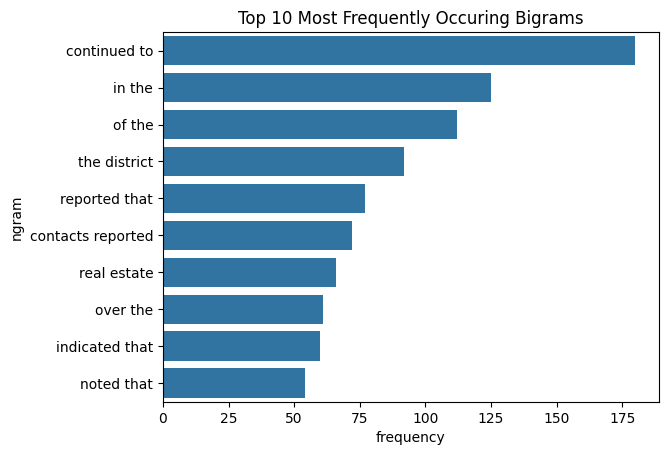

In [91]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data_sub_reg['at']['sentence'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## Boston

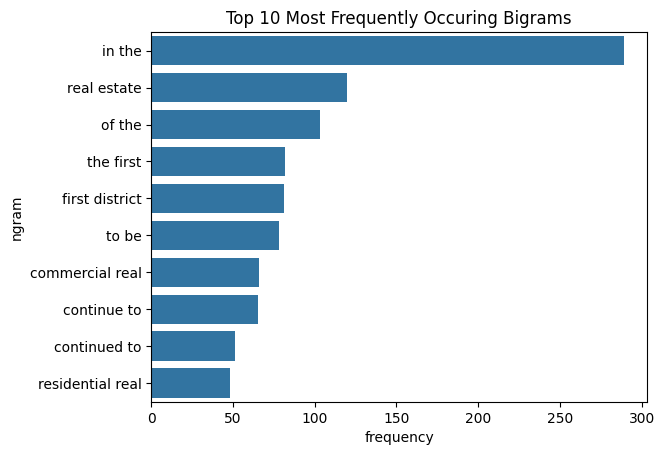

In [95]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data_sub_reg['bo']['sentence'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## Chicago

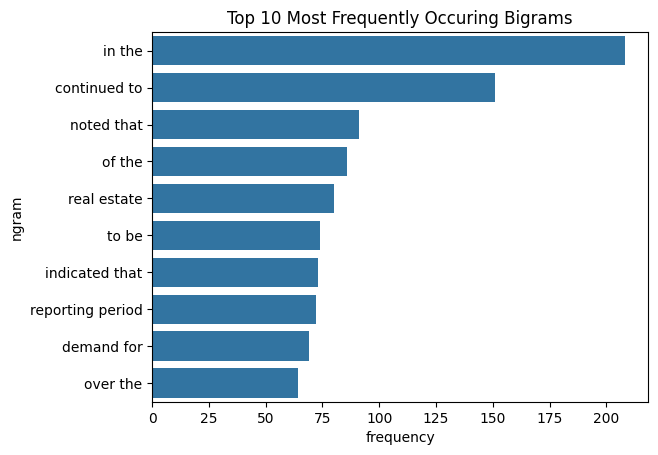

In [96]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data_sub_reg['ch']['sentence'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## Cleveland

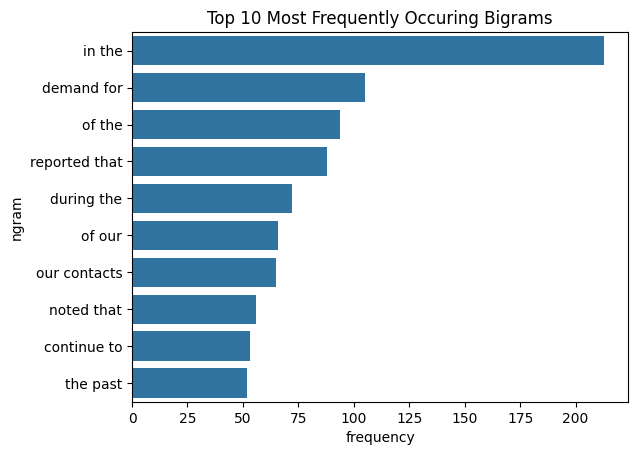

In [99]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data_sub_reg['cl']['sentence'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## Dallas

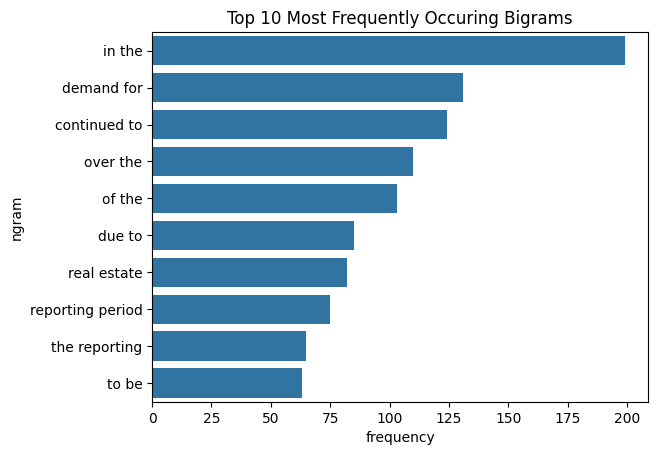

In [100]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data_sub_reg['da']['sentence'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## Kansas City 

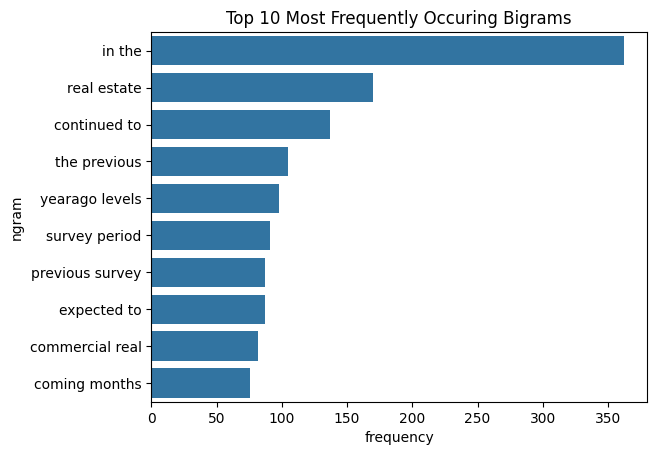

In [102]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data_sub_reg['kc']['sentence'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## Minneapolis

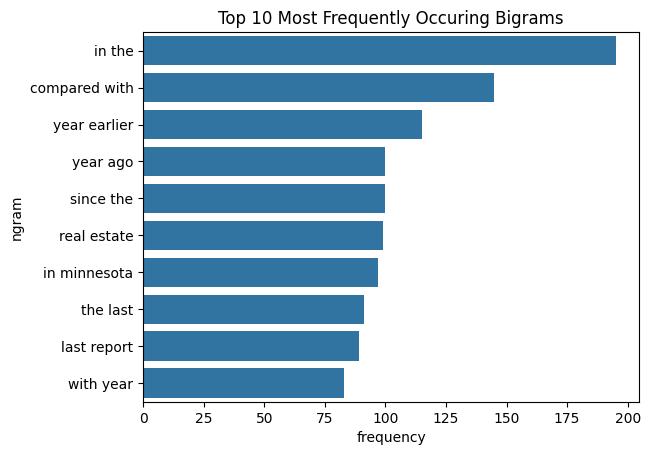

In [105]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data_sub_reg['mi']['sentence'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## New York

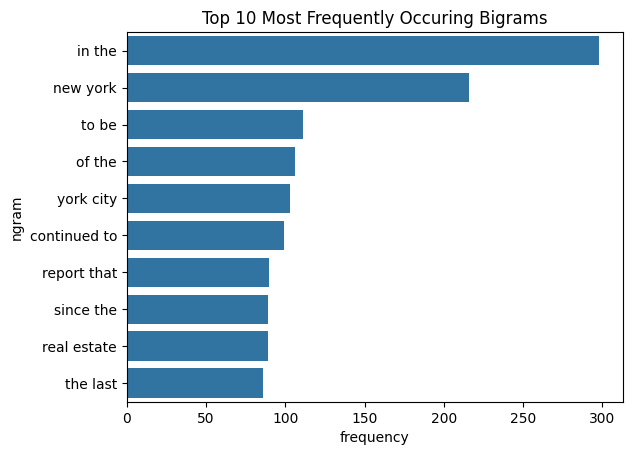

In [106]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data_sub_reg['ny']['sentence'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## Philidelphia

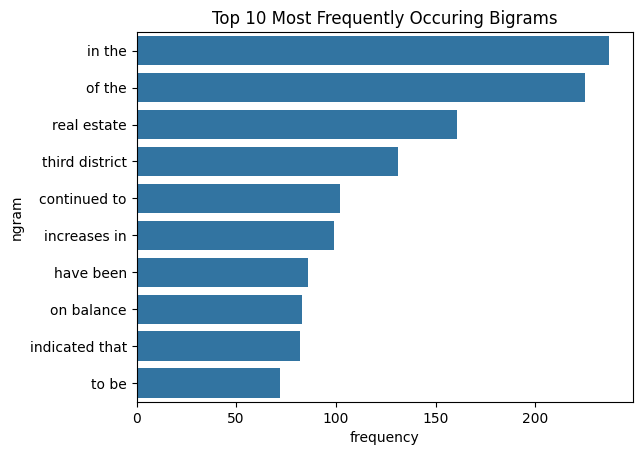

In [107]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data_sub_reg['ph']['sentence'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## Richmond

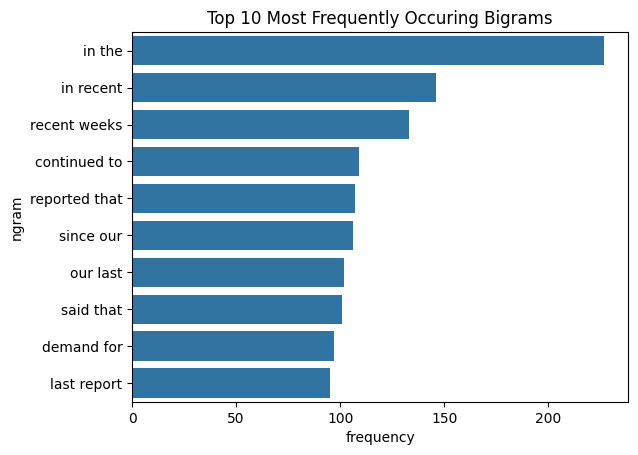

In [108]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data_sub_reg['ri']['sentence'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## San Fransisco

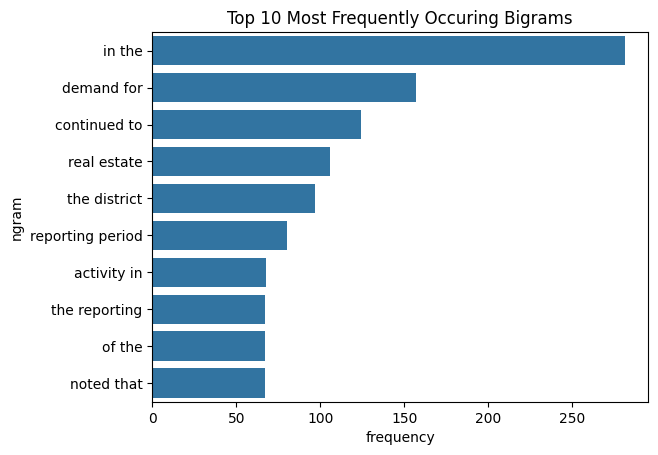

In [110]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data_sub_reg['sf']['sentence'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## St. Louis

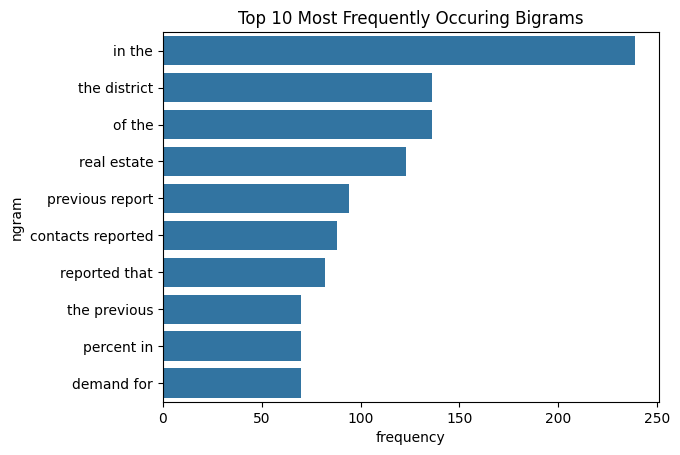

In [111]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data_sub_reg['sl']['sentence'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## National Summary

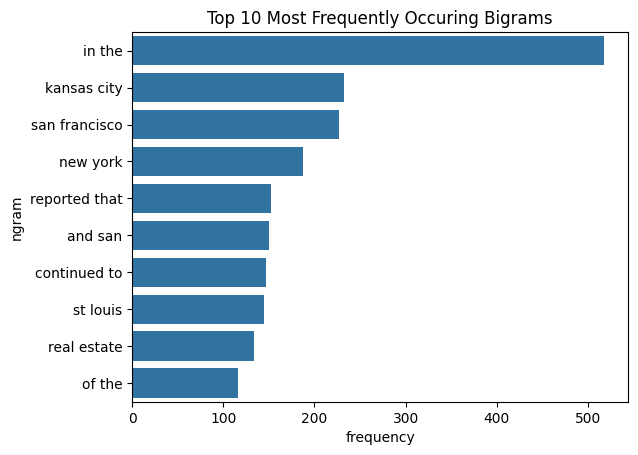

In [112]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data_sub_reg['su']['sentence'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()